# Loss Functions

sMAPE appears to perform far better than MAPE (as compared on CNN Conv1D LSTM on 1000epochs)

However this beavior is not consistent over 3 stocks

# CNN Conv1D LSTM

This model appears to perform shit on apple

## Getting the best hyperparameters for a set of stocks

In [1]:
from keras_tuner import Hyperband
from OptimizeNN_keras import MP_CNN_Bi_Dir_LSTM

import json
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2
from Raw_Data import *
#Setting up GPU computation 
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

os.environ["RUNFILES_DIR"] = "/Library/Frameworks/Python.framework/Versions/3.7/share/plaidml"
# plaidml might exist in different location. Look for "/usr/local/share/plaidml" and replace in above path

os.environ["PLAIDML_NATIVE_PATH"] = "/Library/Frameworks/Python.framework/Versions/3.7/lib/libplaidml.dylib"
# libplaidml.dylib might exist in different location. Look for "/usr/local/lib/libplaidml.dylib" and replace in above path


stocks = ['NOK'] 

for stock in stocks:
    #try,
    #TODO: Write something that detects flat phase of stock and selects date to exclude phase
    data = get_data(stock)
    x_data, x_days, y_data, y_days=format_data_2(data, input_length=50, input_quantfiers=['close'], output_length=1,offset=5, output_quantifiers=['close'], sliding_window = False, scaling_func = None)
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42) #FIXME: Dont randomize data!
    #Finding the best set of parameters and writing it to a file
    tuner = Hyperband(
        hypermodel = MP_CNN_Bi_Dir_LSTM, #TODO: CHeck with BatchNormalization rather than Layer
        max_epochs=100, #TODO: set this to a value slightly higher than the expected epochs to convergence for your largest Mode
        objective="MAPE", #TODO: Change MAPE to something more descriptive, changed loss but also metric?
        factor=3,
        hyperband_iterations=3, #In my interest to set as high as possible, max_epochs * (math.log(max_epochs, factor) ** 2)  one iteration runs prior nr of epochs across trials
        directory='Optimizer',
        project_name= 'MP_CNN_Bi_Dir_LSTM_First_try_{}'.format(stock),
        overwrite=True
        )
    tuner.search(X_train, y_train,
                validation_data=(X_test, y_test),
                callbacks=[TensorBoard("./tb_logs/{}_{}".format(stock, 'MP_CNN_Bi_Dir_LSTM'))])
    print('Completed Search')
    #Saving best parameters
    with open('hyperparameter_best/params','r+') as file:
        try:
            file_data = json.load(file)
        except:
            file_data = {}
        file_data.update({'{}_{}'.format(stock,'MP_CNN_Bi_Dir_LSTM'):tuner.get_best_hyperparameters()[0].get_config()['values']})
    json.dump(file_data,file,indent=4)
    print('Saved hyperparameters')
    print(file_data)
'''
    except Exception as e:
        print('Couln`t compute for ', stock)
        print('Due to: ', e)'''

Trial 10 Complete [00h 00m 27s]
MAPE: 99.43426513671875

Best MAPE So Far: 95.49618530273438
Total elapsed time: 00h 04m 42s

Search: Running Trial #11

Hyperparameter    |Value             |Best Value So Far 
kernel 1          |9                 |9                 
alpha1            |0                 |0.22              
kernel 2          |9                 |9                 
alpha2            |0.66              |0.66              
kernel 3          |5                 |5                 
alpha3            |0.77              |0.99              
learning rate     |0.01              |0.1               
rho               |0.15              |0.2               
epsilon           |0.0001            |0.001             
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |4                 |4                 
tuner/round       |0                 |0                 



# Using best parameters

In [10]:
from keras_tuner import Hyperband
from OptimizeNN_keras import CNN_UNIV_10
from Raw_Data import format_data_2, get_data
from NeuralNetwork import get_data_CNN_UNIV_10

import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'

data = get_data('NOK')
x_data, x_days, y_data, y_days =format_data_2(data, input_length=10, input_quantfiers=['close'], output_length=5,offset=5, output_quantifiers=['close'], sliding_window = False, scaling_func = None)

tuner = Hyperband(
            hypermodel = CNN_UNIV_10,
            max_epochs=100, #TODO: set this to a value slightly higher than the expected epochs to convergence for your largest Mode
            objective="MAPE", 
            factor=3,
            hyperband_iterations=1, #In my interest to set as high as possible, max_epochs * (math.log(max_epochs, factor) ** 2)  one iteration runs prior nr of epochs across trials
            directory='Optimizer',
            project_name= 'CNN_UNIV_10_av_{}'.format('NOK'),
            overwrite=True
            )

tuner.search(x_data, y_data,
                    validation_split=0.2,verbose=1,shuffle=False,batch_size=32)

Trial 100 Complete [00h 00m 01s]
MAPE: 86.61383056640625

Best MAPE So Far: 80.7489013671875
Total elapsed time: 00h 03m 37s

Search: Running Trial #101

Hyperparameter    |Value             |Best Value So Far 
conv1             |4                 |88                
alpha1            |0.4               |0.2               
MaxPool1          |4                 |8                 
dense1            |25                |40                
alpha2            |0.2               |0.3               
alpha3            |0.1               |0.2               
learning rate     |0.01              |0.01              
tuner/epochs      |4                 |2                 
tuner/initial_e...|2                 |0                 
tuner/bracket     |4                 |4                 
tuner/round       |1                 |0                 
tuner/trial_id    |23cc353f25bf62a...|None              

Epoch 3/4


KeyboardInterrupt: 

In [2]:
from tensorflow.keras.callbacks import EarlyStopping
from OptimizeNN_keras import CNN_UNIV_10
from Raw_Data import format_data_2, get_data
from keras_tuner import HyperParameters

data = get_data('NOK')
x_data, x_days, y_data, y_days =format_data_2(data, input_length=10, input_quantfiers=['close'], output_length=1,offset=1, output_quantifiers=['close'], sliding_window = False)
x_data, x_days, y_data, y_days = x_data[-len(x_data)//3::], x_days, y_data[-len(x_data)//3::], y_days

hp = HyperParameters()
hp.Fixed("conv1", 88)
hp.Fixed("alpha1", 0.4)
hp.Fixed("MaxPool1", 4)
hp.Fixed("dense1", 55)
hp.Fixed("alpha2", 0.4)
hp.Fixed("alpha3", 0.6)
hp.Fixed("learning rate", 0.01)

callback = EarlyStopping(monitor='loss', patience=5)

model = CNN_UNIV_10(hp)

model.fit(x_data,y_data,validation_split=0.2,epochs=1000,shuffle=False,batch_size=32,callbacks=[callback])

Epoch 1/1000
4/4 [==============================] - 2s 132ms/step - loss: 1.3861 - MAPE: 79.3364 - val_loss: 1.0505 - val_MAPE: 226.8186
Epoch 2/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.5431 - MAPE: 54.7397 - val_loss: 1.6525 - val_MAPE: 972.6492
Epoch 3/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.5457 - MAPE: 89.5454 - val_loss: 1.7402 - val_MAPE: 1369.9585
Epoch 4/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.5474 - MAPE: 93.6166 - val_loss: 1.6736 - val_MAPE: 1049.4248
Epoch 5/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.4672 - MAPE: 66.7218 - val_loss: 1.4608 - val_MAPE: 555.4602
Epoch 6/1000
4/4 [==============================] - 0s 28ms/step - loss: 0.3469 - MAPE: 37.9228 - val_loss: 1.1089 - val_MAPE: 256.0670
Epoch 7/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.3312 - MAPE: 29.4227 - val_loss: 1.0572 - val_MAPE: 231.0423
Epoch 8/1000
4/4 [===========================

In [26]:
x = 'tunerxyz'
x[:5:]=='tuner'

True

In [2]:
from keras_tuner import Hyperband
from OptimizeNN_keras import CNN_Conv1D_LSTM_sMAPE
tuner = Hyperband(
    hypermodel = CNN_Conv1D_LSTM_sMAPE,
    max_epochs=1000, #TODO: set this to a value slightly higher than the expected epochs to convergence for your largest Mode
    objective="MAPE", #TODO: Change MAPE to something more descriptive, changed loss but also metric?
    factor=5,
    hyperband_iterations=2, #In my interest to set as high as possible, max_epochs * (math.log(max_epochs, factor) ** 2)  one iteration runs prior nr of epochs across trials
    directory='Optimizer',
    project_name= 'CNN_Conv1D_LSTM_{}'.format('NOK')
    )
tuner.reload()

INFO:tensorflow:Reloading Oracle from existing project Optimizer/CNN_Conv1D_LSTM_NOK/oracle.json
INFO:tensorflow:Reloading Tuner from Optimizer/CNN_Conv1D_LSTM_NOK/tuner0.json


In [21]:
models = tuner.get_best_models(num_models=3)
params= tuner.get_best_hyperparameters(num_trials=3)
from Raw_Data import *
data = get_data('NOK')
x_data, x_days, y_data, y_days =format_data_2(data, input_length=10, input_quantfiers=['close'], output_length=1,offset=1, output_quantifiers=['close'], sliding_window = False)
x_data, x_days, y_data, y_days = x_data[-len(x_data)//2::], x_days, y_data[-len(x_data)//2::], y_days

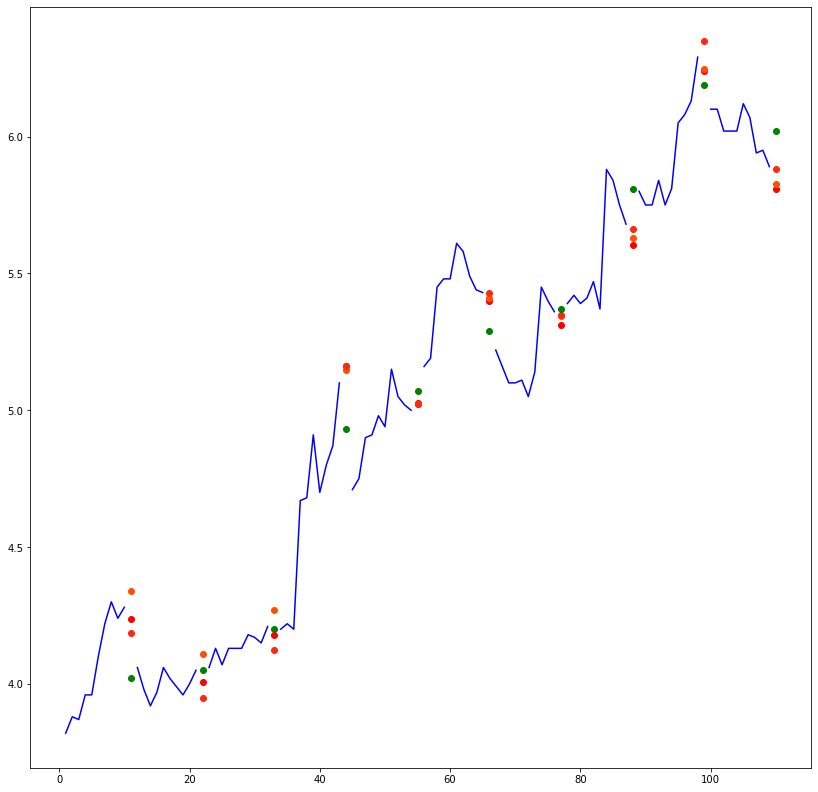

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,14))
index = np.linspace(1,110,110)
count = 0
for i in x_data[-10:]:
    count2 = 0 
    for j in ['r','#ff5000','#ff2812']:
        y_pred=models[count2].predict(np.array([i]))
        count2+=1
        plt.scatter(index[10], y_pred,c=j,label='prediction')
    plt.plot(index[0:10],np.array(i).flatten(),c='b',label='Orig')
    plt.scatter(index[10], y_data[-10+count],c='g',label='actual')
    index = index[11:]
    count+=1



In [4]:
%matplotlib inline

<AxesSubplot:xlabel='Date'>

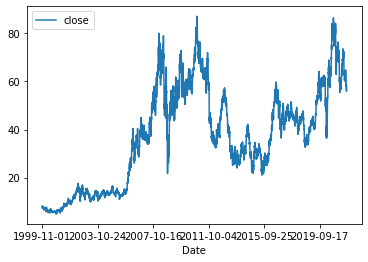

In [5]:
import pandas as pd
dat = pd.read_csv("stockdata/AEM.csv", parse_dates=True, sep=' ', names=['Date', 'open', 'high', 'low', 'close', 'volume'])
dat.plot(x='Date',y='close')

[array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])]


In [39]:
zeros = 0
count = 0
for i in res:
    if i == 0:
        zeros += 1
if zeros > 0:
    print('The model predicted {} zero values'.format(zeros))
if (int(0) in y_dat) or (float(0) in y_dat):
    index = np.where(y_dat==0)
    for i in index: #Delete all rows with 0 values #TODO: This should not be required, remove at some point
        count += 1
        y_dat = np.delete(y_dat, i)
        y_days_dat = np.delete(y_days_dat, i)
        x_dat = np.delete(x_dat, i, axis=0)
        x_days_dat = np.delete(x_days_dat, i, axis=0)
    print('Had to delete {} items from input data'.format(count))
if val:
    res = model_MAPE.predict(x_val)
    diff = abs(res.flatten()-y_val.flatten())/y_val.flatten()
    res1 = model_sMAPE.predict(x_val)
    diff1 = abs(res1.flatten()-y_val.flatten())/y_val.flatten()
else:
    res = model_MAPE.predict(x_dat)
    diff = abs(res.flatten()-y_dat.flatten())/y_dat.flatten()
    res1 = model_sMAPE.predict(x_dat)
    diff1 = abs(res1.flatten()-y_dat.flatten())/y_dat.flatten()


Had to delete 1 items from input data


<function matplotlib.pyplot.show(close=None, block=None)>

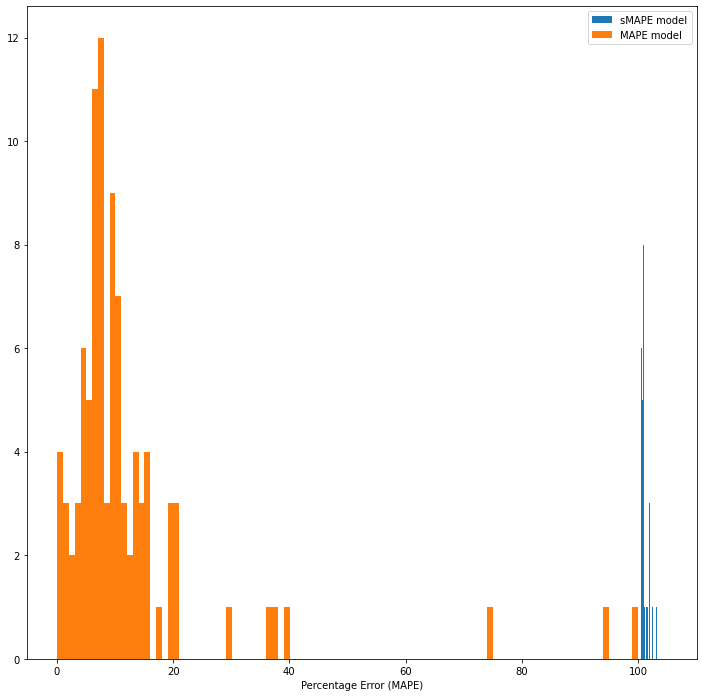

In [40]:
fig = plt.figure(figsize=(12,12))
plt.hist(diff*100,bins=100,label='sMAPE model')
plt.hist(diff1*100,bins=100,label='MAPE model')
plt.xlabel('Percentage Error (MAPE)')
plt.legend()
plt.show

ValueError: x and y must have same first dimension, but have shapes (96,) and (95, 1)

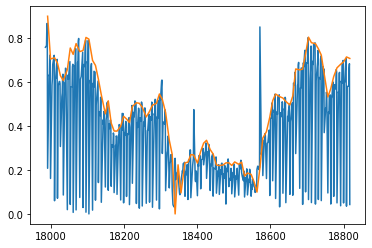

In [46]:
from matplotlib.dates import datestr2num
#x_days_dat = datestr2num(x_days_dat.flatten())
y_days_dat = datestr2num(y_days_dat)
plt.plot(x_days_dat,x_dat[::, 3].flatten())
plt.plot(y_days_dat,y_dat)
plt.plot(y_days_dat,res,label='MAPE') #FIXME: Thing predicts zeros again
plt.plot(y_days_dat,res1,label='sMAPE')

In [1]:
from keras_tuner import Hyperband
from OptimizeNN_keras import MP_CNN_Bi_Dir_LSTM,MP_CNN_Bi_Dir_LSTM_submodel
from Raw_Data import *
import json
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters
from sklearn.preprocessing import MinMaxScaler

stock = 'NOK'

data = get_data(stock)
x_data, x_days, y_data, y_days, minmax_args=format_data_2(data, input_length=50, input_quantfiers=['close'], output_length=1,offset=5, output_quantifiers=['close'], sliding_window = False, scaling_func = 'MinMax')

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42) #FIXME: Dont randomize data!
#Finding the best set of parameters and writing it to a file
hp = HyperParameters()
hp.Fixed('kernel 1',value=5)
hp.Fixed('kernel 2',value=9)
hp.Fixed('kernel 3',value=5)
hp.Fixed('learning rate',value=0.5)
hp.Fixed('rho',value=0.95)
hp.Fixed('epsilon',value=1e-7)
hp.Fixed('alpha 1',value=0.2)
hp.Fixed('alpha 2',value=0.2)
hp.Fixed('alpha 3',value=0.2)

submodel = MP_CNN_Bi_Dir_LSTM_submodel(hp)
model = MP_CNN_Bi_Dir_LSTM(hp)

submodel.summary()
model.summary()

#hist = model.fit(X_train, y_train, batch_size=32, epochs = 10,validation_data=(X_test,y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 46, 128)           768       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 46, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 128)           147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 128)            8

In [2]:
print(hist.history)

{'loss': [0.4532053470611572, 0.32000094652175903, 0.32755351066589355, 0.2996422052383423, 0.2870514392852783, 0.2922588586807251, 0.28738129138946533, 0.2965483069419861, 0.2813125252723694, 0.32208847999572754], 'MAPE': [168.5010986328125, 231.94076538085938, 223.78948974609375, 253.53250122070312, 283.3701171875, 253.41213989257812, 300.330078125, 292.89080810546875, 234.4539031982422, 392.84808349609375], 'val_loss': [0.2637602984905243, 0.25620877742767334, 0.2563323378562927, 0.24694523215293884, 0.2362317442893982, 0.23236128687858582, 0.2298649698495865, 0.23749738931655884, 0.24081431329250336, 0.34374475479125977], 'val_MAPE': [205.3405303955078, 216.64443969726562, 235.72747802734375, 226.13262939453125, 199.1488037109375, 214.01913452148438, 168.078857421875, 148.4708709716797, 247.13255310058594, 95.86151123046875]}


In [3]:
y_pred = model.predict(X_test)

In [4]:
print(y_pred)

[[ 0.02391753]
 [-0.07301527]
 [-0.01974191]
 [ 0.07114065]
 [ 0.08435704]
 [ 0.05615152]
 [ 0.26662263]
 [ 0.00960946]
 [ 0.02873563]
 [ 0.20085156]
 [ 0.23318231]
 [-0.04559582]
 [ 0.03565362]
 [ 0.1856544 ]
 [-0.05114789]
 [ 0.00121329]
 [ 0.00028744]
 [ 0.22005603]
 [ 0.21312633]
 [ 0.14001743]
 [ 0.11570157]
 [ 0.19501227]
 [ 0.03355745]
 [ 0.01625155]
 [ 0.04051109]
 [ 0.18225408]
 [ 0.14843872]
 [-0.04592046]
 [ 0.18679038]
 [ 0.15926172]
 [ 0.21119082]
 [ 0.08446349]
 [-0.04349399]]
